In [0]:
import torch #基本モジュール
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torchvision.models as models
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [0]:
#MLPモジュール
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layer_num=2):
        super(MLP, self).__init__()
        
        self.linears_prediction = torch.nn.ModuleList()
        
        self.linears_prediction.append(
                    nn.Linear(input_dim, hidden_dim))
        
        for layer in range(layer_num-2):
            self.linears_prediction.append(
                    nn.Linear(hidden_dim, hidden_dim))
                
        self.linears_prediction.append(
                    nn.Linear(hidden_dim, output_dim))
        
    def forward(self, x):
      
        for i in range(len(self.linears_prediction)-1):
            x = torch.relu(self.linears_prediction[i](x))
            
        x = self.linears_prediction[-1](x)
        
        return x


#Attentive neural process用のMulti_head_self_attention
class Multi_head_Attention(nn.Module):
    def __init__(self, key_dim, value_dim, embed_dim, num_heads=4, concat=True):
        super(Multi_head_Attention, self).__init__()
        self.concat = concat
        
        self.attntion = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp_key = MLP(key_dim, embed_dim, embed_dim)
        self.mlp_value = MLP(value_dim, embed_dim, embed_dim)
        self.mlp_query = MLP(key_dim, embed_dim, embed_dim)
        
        if concat:
          self.final_linear = MLP(key_dim+embed_dim, embed_dim, embed_dim)
          self.residual_dropout = nn.Dropout(p=0.1)
          self.layer_norm = nn.LayerNorm(embed_dim)
       
    def forward(self, x_t, x_c, r_a):
      
        k_embed = self.mlp_key(x_c).transpose(1,0)
        v_embed = self.mlp_value(r_a).transpose(1,0)
        q_embed = self.mlp_query(x_t).transpose(1,0)
        
        query, _ = self.attntion(q_embed, k_embed, v_embed, need_weights=False)
        query = query.transpose(1,0)

        if self.concat:
          query_ = torch.cat([x_t, query], dim=-1)
          query_ = self.final_linear(query_)
          query_ =  self.residual_dropout(query_)
          query = query + query_
          query =  self.layer_norm(query)
       
        return query

#Attentive neural process用のself_attention
class Self_Attention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads=1):
        super(Self_Attention, self).__init__()
        
        self.attntion = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp_key = MLP(input_dim, embed_dim, embed_dim)
        self.mlp_value = MLP(input_dim, embed_dim, embed_dim)
        self.mlp_query = MLP(input_dim, embed_dim, embed_dim)
        
    def forward(self, x):
      
        k_embed = self.mlp_key(x).transpose(1,0)
        v_embed = self.mlp_value(x).transpose(1,0)
        q_embed = self.mlp_query(x).transpose(1,0)
        
        query, _ = self.attntion(q_embed, k_embed, v_embed, need_weights=False)
        
        return query.transpose(1,0)

#deterministic path
class R_encoder(nn.Module):
    def __init__(self, x_dim, y_dim, d_dim, r_dim, mlp_num=2, self_attention=False):
        super(R_encoder, self).__init__()
        
        self.mlp = MLP(x_dim+y_dim, d_dim, d_dim, mlp_num)
        if self_attention:
            self.fc = Self_Attention(d_dim, r_dim)
        else:
            self.fc = nn.Linear(d_dim, r_dim)
                
        
    def forward(self, x, y): #MNISTならx:(batch, length, (x,y)) y:(batch, length, 1)
        
        r = torch.cat([x, y], dim=2)
        r = torch.relu(self.mlp(r))
        r = self.fc(r)
        
        return  r

#Latent path
class S_encoder(nn.Module):
    def __init__(self, x_dim, y_dim, d_dim, z_dim, mlp_num=1, self_attention=False):
        super(S_encoder, self).__init__()

        self.z_dim = z_dim
        
        self.mlp = MLP(x_dim+y_dim, d_dim, d_dim, mlp_num)
        self.fc2 = nn.Linear(d_dim, d_dim)
        self.fc3 = nn.Linear(d_dim, z_dim)
        self.fc4 = nn.Linear(d_dim, z_dim)
        if self_attention:
            self.fc1 = Self_Attention(d_dim, d_dim)
        else:
            self.fc1 = nn.Linear(d_dim, d_dim)
            
    def forward(self, x, y): #MNISTならx:(batch, length, (x,y)) y:(batch, length, 1)
        z = torch.cat([x, y], dim=2)
        
        z = torch.relu(self.mlp(z))
        z = torch.relu(self.fc1(z)).mean(1, keepdim=True)
        z = torch.relu(self.fc2(z))

        z_mu = self.fc3(z)
        z_scale = self.fc4(z)
        z_scale = 0.1 + 0.9*torch.sigmoid(z_scale)
        return z_mu,  z_scale

#Decoder
class Decoder(nn.Module):
    def __init__(self, x_dim, y_dim, d_dim, z_dim, r_dim, mlp_num=2):
        super(Decoder, self).__init__()
        self.y_dim = y_dim
        self.mlp = MLP(x_dim+z_dim+r_dim, d_dim, d_dim, mlp_num)
        self.fc = nn.Linear(d_dim, y_dim*2)
            

    def forward(self, x_, r, z):
        y = torch.cat([x_, r, z.repeat(1, x_.size(1), 1)], dim=2)
        y = torch.relu(self.mlp(y))
        y = self.fc(y)
        y_mu = y[:, :, :self.y_dim]
        y_scale = 0.1 + 0.9*F.softplus(y[:, :, self.y_dim:])
        return  y_mu, y_scale


class KL_divergence(nn.Module):
    def __init__(self):
        super(KL_divergence, self).__init__()
        
    def forward(self, mu, sigma, nu, tau):

        return (((sigma**2 + (mu - nu)**2) / tau**2 - 1 + 2 * torch.log(tau / sigma)).sum(1) / 2)

class Log_Likelihood(nn.Module):
    def __init__(self):
        super(Log_Likelihood, self).__init__()
    
    def forward(self, mu, sigma, y):  #(batch, 要素, 出力数)
        
        sigma = sigma**2 #+ 1e-8
        det_sigma =  sigma.prod(dim=2, keepdim=True)
        
        return ((((y - mu) * (1 / sigma) * (y - mu)).sum(2, keepdim=True) + torch.log(det_sigma) + np.log(np.pi*2) * y.size(-1)) / -2.0).mean(1)
        

#MNIST, FashionMNIST用のデータ生成
def context_target_random_split(train_X): 
    """
    学習ではN_n=3〜200個の(x_c, y_c)と200-N_n個の(x_t,)が必要なので毎回生成
    y_tは正解ラベル
    """
    N = train_X.size(0)
    H = train_X.size(2)
    W = train_X.size(3)
    train_index = torch.Tensor([[i*1., j*1.] for i in range(H) for j in range(W)]).to(device)
    train_index = (torch.cat([train_index.unsqueeze(0)] * N, dim=0) / (H-1)) * 2. - 1.  #[-1,1]に正規化 (batch, H*W, 2)
    train_y = train_X.contiguous().view(N, -1, 1) #(batch, H*W, 1)
    
    #各バッチの要素ごとにrandomで混ぜる
    perm = np.hstack([np.random.permutation(H*W)+(H*W*i) for i in range(N)])
    #print(train_index.size())
    train_index = train_index.contiguous().view(-1, 2)[perm].contiguous().view(N, -1, 2)
    train_y = train_y.flatten()[perm].contiguous().view(N, -1, 1)
    
    N_n = np.random.choice(np.arange(3, 200))
    N_m = N_n + np.random.choice(np.arange(0, 200 - N_n))
    x_c, y_c = train_index[:, :N_n], train_y[:, :N_n]
    x_t, y_t = train_index[:, :N_n+N_m], train_y[:, :N_n+N_m]
    return x_c, x_t, y_c, y_t


#1次元回帰用のデータ生成器
def make_data_1D():
    """
    Gaussian kernelに従う関数を生成
    """
    sigma_f = np.random.rand() + 0.1 # 垂直の変化のスケールのハイパーパラメータ[0.1, 1.0]
    l = np.random.rand()/2. + 0.1  # 水平の変化のスケールのハイパーパラメータ[0.1, 0.6]
    Nx = 100

    def k(x, y):

        return sigma_f ** 2 * np.exp(- ((x - y) ** 2) / (2 * l ** 2)) + (0.02**2) * np.eye(Nx) #正定値を保証するため
    
    
    def multivariate_normal(cov):
        L = np.linalg.cholesky(cov) #コレスキー分解
        z = np.random.standard_normal(len(cov)) #標準正規乱数ベクトル
        return np.dot(L, z) #行列Lとベクトルzの積
    
    x = np.random.rand(Nx) * 2. - 1.
    X, Y = np.meshgrid(x, x)
    K = k(X,Y)
    y = multivariate_normal(K) 
    return x, y

def context_target_random_split_1D(data_x, data_y):
    """
    学習ではN_n=3〜100個の(x_c, y_c)と100-N_n個の(x_t,)が必要なので毎回生成
    y_tは正解ラベル
    """
    
    N_n = np.random.choice(np.arange(3, 100))
    N_m = np.random.choice(np.arange(0, 100 - N_n))
    
    N = data_x.shape[1]
    perm = np.random.permutation(np.arange(N))
    data_x, data_y = data_x[:, perm], data_y[:, perm]
    
    x_c = data_x[:, :N_n]
    y_c = data_y[:, :N_n]  
    x_t = data_x[:, :N_n+N_m]
    y_t = data_y[:, :N_n+N_m]
    
    return x_c, x_t, y_c, y_t

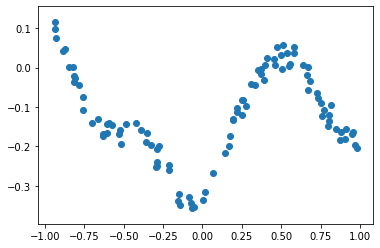

In [0]:
#データ生成例
x, y = make_data_1D()
plt.scatter(x, y)

cuda


In [0]:
#1次元バージョンの回帰
#パラメータ
z_dim = 128
r_dim = 128
d_dim = 150
x_dim = 1
y_dim = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, flush=True)

r_encoder = R_encoder(x_dim, y_dim, d_dim, r_dim, self_attention=True).to(device) # (x,y)->r
s_encoder = S_encoder(x_dim, y_dim, d_dim, z_dim, self_attention=True).to(device) # (x,y)->z
mh_attention = Multi_head_Attention(x_dim, r_dim, r_dim, num_heads=8).to(device)
decoder = Decoder(x_dim, y_dim, d_dim, z_dim, r_dim).to(device) # (x*, r, z) -> y*
kl_divergence = KL_divergence().to(device)
log_Likelihood = Log_Likelihood().to(device)
opt_d = torch.optim.Adam(decoder.parameters(), 1e-4)
opt_r = torch.optim.Adam(r_encoder.parameters(), 1e-4)
opt_s = torch.optim.Adam(s_encoder.parameters(), 1e-4)
opt_a = torch.optim.Adam(mh_attention.parameters(), 1e-4)

r_encoder.train()
s_encoder.train()
mh_attention.train()
decoder.train()


# 訓練
train_loss = 0.
batch_size = 30
get_points = 4 #関数は変えずに獲得点だけを変える操作の回数

for i in range(30000):
  
    # context target split
    x_list = []
    y_list = []
    for b in range(batch_size):
        data_x, data_y = make_data_1D()
        x_list += [data_x]
        y_list += [data_y]
    
    data_x = torch.Tensor(x_list).float().to(device).contiguous().view(batch_size, -1, x_dim)
    data_y = torch.Tensor(y_list).float().to(device).contiguous().view(batch_size, -1, y_dim)
    for j in range(get_points): 
        opt_d.zero_grad()
        opt_r.zero_grad()
        opt_s.zero_grad()
        opt_a.zero_grad()
        x_c, x_t, y_c, y_t = context_target_random_split_1D(data_x, data_y)

        r = r_encoder(x_c, y_c)
        r_mean = mh_attention(x_t, x_c, r)

        t_mu,  t_sigma = s_encoder(x_t, y_t)
        c_mu, c_sigma = s_encoder(x_c, y_c)

        t_z = torch.distributions.Normal(0.0, 1.0).sample(t_mu.size()).to(device)*t_sigma + t_mu

        mu, sigma = decoder(x_t, r_mean, t_z)

        kl = kl_divergence(t_mu,  t_sigma, c_mu, c_sigma).mean()
        ll = log_Likelihood(mu, sigma, y_t)
        loss = kl.mean() - ll.mean()

        loss.backward()
        opt_d.step()
        opt_r.step()
        opt_s.step()
        opt_a.step()

        train_loss += loss.item()

    # print statistics
    if (i+1) % 500 == 0:
      print("i: %d train_mean_loss %f" %(i+1, train_loss/(500*2)))
      train_loss = 0.

i: 500 train_mean_loss -1.988202
i: 1000 train_mean_loss -1.983120
i: 1500 train_mean_loss -2.011178
i: 2000 train_mean_loss -2.070533
i: 2500 train_mean_loss -2.111909
i: 3000 train_mean_loss -2.089760
i: 3500 train_mean_loss -2.072363
i: 4000 train_mean_loss -2.148615
i: 4500 train_mean_loss -2.129896
i: 5000 train_mean_loss -2.116641
i: 5500 train_mean_loss -2.151694
i: 6000 train_mean_loss -2.133606
i: 6500 train_mean_loss -2.105709
i: 7000 train_mean_loss -2.198707
i: 7500 train_mean_loss -2.178588
i: 8000 train_mean_loss -2.161698
i: 8500 train_mean_loss -2.154617
i: 9000 train_mean_loss -2.127814
i: 9500 train_mean_loss -2.202831
i: 10000 train_mean_loss -2.168825
i: 10500 train_mean_loss -2.222575
i: 11000 train_mean_loss -2.171509
i: 11500 train_mean_loss -2.269705
i: 12000 train_mean_loss -2.197255
i: 12500 train_mean_loss -2.206057
i: 13000 train_mean_loss -2.252359
i: 13500 train_mean_loss -2.228491
i: 14000 train_mean_loss -2.216927
i: 14500 train_mean_loss -2.231901
i: 15

In [0]:
#1次元テストデータの生成
def context_target_random_split_1D_test(context_num, gaussian=True):
    """
    gaussian=True : Gaussian kernelに従う関数
    gaussian=False : 適当な三角関数
    """
    if gaussian:
      sigma_f = np.random.rand() + 0.1 # 垂直の変化のスケールのハイパーパラメータ[0.1, 1.0]
      l = np.random.rand()/2. + 0.1  # 水平の変化のスケールのハイパーパラメータ[0.1, 0.6]

      def k(x, y):
          return sigma_f ** 2 * np.exp(- ((x - y) ** 2) / (2 * l ** 2))
        
      """
      x_c = np.random.rand(context_num) * 2. - 1.
      X, Y = np.meshgrid(x_c, x_c)
      K = np.vectorize(k)(X, Y)
      y_c = np.random.multivariate_normal(x_c*0 , K) + np.random.normal(0, 0.02, context_num)
      """
      x_t = np.arange(0, 1, 0.001) * 2. - 1.
      X, Y = np.meshgrid(x_t, x_t)
      K = k(X,Y)
      y_t = np.random.multivariate_normal(x_t*0 , K)
      x_c_index = np.random.choice(range(1000), context_num)
      x_c = x_t[x_c_index]
      y_c = y_t[x_c_index] + np.random.normal(0, 0.02, context_num)
    
    else:
      scale = np.random.rand() + 0.5 #垂直の変化のスケールのハイパーパラメータ[0.5, 1.5]
      
      x_t = np.arange(0, 1, 0.001)
      y_t = scale * np.sin(2 * np.pi * x_t) * np.cos(4 * np.pi * x_t)
      x_c_index = np.random.choice(range(1000), context_num)
      x_c = x_t[x_c_index]
      y_c = y_t[x_c_index] + np.random.normal(0, 0.02, context_num)
    
    return x_c.reshape(-1, context_num, 1), x_t.reshape(-1, 1000, 1), y_c.reshape(-1, context_num, 1), y_t.reshape(-1, 1000, 1)

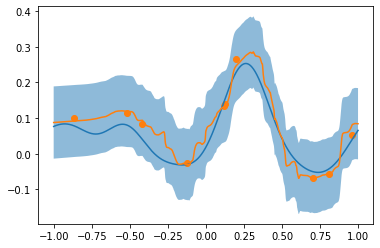

In [0]:
r_encoder.eval()
s_encoder.eval()
mh_attention.eval()
decoder.eval()

#与えるデータ点数
context_num = 10

#回帰を行う

x_c, x_t, y_c, y_t = context_target_random_split_1D_test(context_num, gaussian=True)
x_c = torch.from_numpy(x_c.astype("float32")).to(device)
x_t = torch.from_numpy(x_t.astype("float32")).to(device)
y_c = torch.from_numpy(y_c.astype("float32")).to(device)
y_t = torch.from_numpy(y_t.astype("float32")).to(device)

r = r_encoder(x_c, y_c)
r_mean = mh_attention(x_t, x_c, r)

t_mu,  t_sigma = s_encoder(x_t, y_t)
c_mu, c_sigma = s_encoder(x_c, y_c)

c_z = torch.distributions.Normal(0.0, 1.0).sample(t_mu.size()).to(device)*c_sigma + c_mu

mu, sigma = decoder(x_t, r_mean, c_z)
z = torch.distributions.Normal(mu, sigma).sample()

#可視化 
#オレンジ実線：事後平均
#青実線：真の関数
#帯：事後標準偏差の1倍区間
#オレンジ点：観測済みデータ
plot_mu = mu.detach().cpu().numpy().flatten()
plot_sigma = sigma.detach().cpu().numpy().flatten()
plot_x = x_t.cpu().numpy().flatten()
plot_y =  y_t.cpu().numpy().flatten()

plt.plot(plot_x, plot_y)
plt.plot(plot_x, plot_mu)
plt.fill_between(plot_x, plot_mu-plot_sigma, plot_mu+plot_sigma, alpha=0.5)
plt.scatter(x_c.cpu().numpy().flatten(), y_c.cpu().numpy().flatten())

In [0]:
#MNISTデータセット

class ts1():
    def __init__(self):
        """
        Args:
            im_size: crop size
        """

    def __call__(self, sample):
        sample =  sample  - 0.5 #スケールを-0.5~0.5に変更
        

        return sample


      
transform1 = transforms.Compose(
    [transforms.ToTensor(),
     ts1()])
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     ts1()])
trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform1)
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=128,
                                            shuffle=True,
                                            num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform2)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=128,
                                            shuffle=False, 
                                            num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27976047.81it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 456222.83it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145008.09it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 7190039.28it/s]                            
8192it [00:00, 171589.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
#FashionMNISTデータセット

class ts1():
    def __init__(self):
        """
        Args:
            im_size: crop size
        """

    def __call__(self, sample):
        sample =  sample  - 0.5  #スケールを-0.5~0.5に変更
        

        return sample
         
transform1 = transforms.Compose(
    [transforms.ToTensor(),
     ts1()])
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     ts1()])

fashion_mnist_data = torchvision.datasets.FashionMNIST(
    './fashion-mnist',
    transform=transform1,
    download=True)

trainloader = torch.utils.data.DataLoader(
    dataset=fashion_mnist_data,
    batch_size=128,
    shuffle=True,
    num_workers=2)

fashion_mnist_data_test = torchvision.datasets.FashionMNIST(
    './fashion-mnist',
    transform=transform2,
    train=False,
    download=True)

testloader = torch.utils.data.DataLoader(
    dataset=fashion_mnist_data_test,
    batch_size=128,
    shuffle=False,
    num_workers=2)

In [0]:
#2次元バージョンの回帰
#パラメータ
z_dim = 128
r_dim = 128
d_dim = 150
x_dim = 2
y_dim = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, flush=True)

r_encoder = R_encoder(x_dim, y_dim, d_dim, r_dim, self_attention=True).to(device) # (x,y)->r
s_encoder = S_encoder(x_dim, y_dim, d_dim, z_dim, self_attention=True).to(device) # (x,y)->z
mh_attention = Multi_head_Attention(x_dim, r_dim, r_dim, num_heads=8).to(device)
decoder = Decoder(x_dim, y_dim, d_dim, z_dim, r_dim).to(device) # (x*, r, z) -> y*
kl_divergence = KL_divergence().to(device)
log_Likelihood = Log_Likelihood().to(device)
opt_d = torch.optim.Adam(decoder.parameters(), 1e-4)
opt_r = torch.optim.Adam(r_encoder.parameters(), 1e-4)
opt_s = torch.optim.Adam(s_encoder.parameters(), 1e-4)
opt_a = torch.optim.Adam(mh_attention.parameters(), 1e-4)

r_encoder.train()
s_encoder.train()
mh_attention.train()
decoder.train()

get_points = 2 #画像は変えずに獲得点だけを変える操作の回数

# 訓練
train_loss = 0.

for i in range(50):
  
    for j, (inputs, labels) in enumerate(trainloader):
      
        inputs =  inputs.to(device)
        
        for m in range(get_points):
            opt_d.zero_grad()
            opt_r.zero_grad()
            opt_s.zero_grad()
            opt_a.zero_grad()

            #context_target_random_split(inputs)
            x_c, x_t, y_c, y_t = context_target_random_split(inputs)

            r = r_encoder(x_c, y_c)
            r_mean = mh_attention(x_t, x_c, r)

            t_mu,  t_sigma = s_encoder(x_t, y_t)
            c_mu, c_sigma = s_encoder(x_c, y_c)
            #print(t_mu.size())
            #t_mu_,  t_sigma_ = t_mu.repeat(1, x_t.size(1), 1), t_sigma.repeat(1, x_t.size(1), 1)

            t_z = torch.distributions.Normal(0.0, 1.0).sample(t_mu.size()).to(device)*t_sigma + t_mu
            #c_z = torch.distributions.Normal(0.0, 1.0).sample(t_mu.size())*c_sigma + c_mu

            mu, sigma = decoder(x_t, r_mean, t_z)

            kl = kl_divergence(t_mu,  t_sigma, c_mu, c_sigma).mean()
            ll = log_Likelihood(mu, sigma, y_t)
            #print(kl.mean().item(),  ll.mean().item())
            loss = kl.mean() - ll.mean()

            loss.backward()
            opt_d.step()
            opt_r.step()
            opt_s.step()
            opt_a.step()

            train_loss += loss.item()

    # print statistics
    print("i: %d train_mean_loss %f" %(i+1, train_loss/(5*len(trainloader))))
    train_loss = 0.

cuda
i: 1 train_mean_loss -0.155019
i: 2 train_mean_loss -0.261561
i: 3 train_mean_loss -0.291994
i: 4 train_mean_loss -0.307320
i: 5 train_mean_loss -0.322981
i: 6 train_mean_loss -0.331868
i: 7 train_mean_loss -0.336060
i: 8 train_mean_loss -0.339506
i: 9 train_mean_loss -0.346627
i: 10 train_mean_loss -0.344870
i: 11 train_mean_loss -0.347646
i: 12 train_mean_loss -0.352250
i: 13 train_mean_loss -0.353835
i: 14 train_mean_loss -0.357325
i: 15 train_mean_loss -0.354847
i: 16 train_mean_loss -0.362759
i: 17 train_mean_loss -0.362797
i: 18 train_mean_loss -0.360429
i: 19 train_mean_loss -0.363215
i: 20 train_mean_loss -0.363782
i: 21 train_mean_loss -0.365677
i: 22 train_mean_loss -0.363683
i: 23 train_mean_loss -0.368834
i: 24 train_mean_loss -0.364776
i: 25 train_mean_loss -0.369882
i: 26 train_mean_loss -0.369116
i: 27 train_mean_loss -0.369873
i: 28 train_mean_loss -0.373146
i: 29 train_mean_loss -0.371698
i: 30 train_mean_loss -0.367741
i: 31 train_mean_loss -0.372084
i: 32 train_

In [0]:
 #MNIST, FashionMNIST用テストデータ生成

def context_target_random_split_test(test_X, N_n=10):
    
    N = test_X.size(0)
    H = test_X.size(2)
    W = test_X.size(3)
    test_index = torch.Tensor([[i*1., j*1.] for i in range(H) for j in range(W)]).to(device)
    test_index = (torch.cat([test_index.unsqueeze(0)] * N, dim=0) / (H-1)) * 2. - 1. #[-1,1]に正規化 (batch, H*W, 2)
    test_y = test_X.contiguous().view(N, -1, 1) #(batch, H*W, 1)
    
    #各バッチの要素ごとにrandomで混ぜる
    perm = np.hstack([np.random.permutation(H*W)+(H*W*i) for i in range(N)])
    test_index_ = test_index.contiguous().view(-1, 2)[perm].contiguous().view(N, -1, 2)
    test_y_ = test_y.flatten()[perm].contiguous().view(N, -1, 1)
    
    x_c, y_c = test_index_[:, :N_n], test_y_[:, :N_n]
    x_t, y_t = test_index, test_y
    
    return x_c, x_t, y_c, y_t 

In [0]:
r_encoder.eval()
s_encoder.eval()
mh_attention.eval()
decoder.eval()

context_num = 50 #獲得点数

for j, (inputs, labels) in enumerate(testloader):
      
        inputs =  inputs.to(device)
        
        opt_d.zero_grad()
        opt_r.zero_grad()
        opt_s.zero_grad()
        opt_a.zero_grad()
        
        x_c, x_t, y_c, y_t = context_target_random_split_test(inputs, N_n=context_num)
        #x_c, x_t, y_c, y_t = context_target_random_split_test_(inputs)
       
        break #1イテレーションで終了

r = r_encoder(x_c, y_c)
r_mean = mh_attention(x_t, x_c, r)

t_mu,  t_sigma = s_encoder(x_t, y_t)
c_mu, c_sigma = s_encoder(x_c, y_c)

c_z = torch.distributions.Normal(0.0, 1.0).sample(t_mu.size()).to(device)*c_sigma + c_mu

mu, sigma = decoder(x_t, r_mean, c_z)
z = torch.distributions.Normal(mu, sigma).sample()



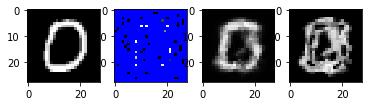

In [0]:
#可視化
#右から, 元画像, 獲得点, 平均, 標準偏差

select_num = 10 #表示インデックス

x_c_ = np.round(((x_c.detach().cpu().numpy()[select_num] + 1)*27 / 2.)).astype(int)
y_c_plt = np.zeros((28,28,3), dtype=float)
y_c_plt[:,:,2] = 1.
y_c_ = y_c.detach().cpu().numpy()[select_num] + 0.5

for i in range(len(x_c_)):
    y_c_plt[x_c_[i][0], x_c_[i][1], :] = y_c_[i][0]

ax = plt.subplot(1, 4, 1)
plt.imshow(y_t.detach().cpu().numpy()[select_num].reshape(28,28))
plt.gray()
ax = plt.subplot(1, 4, 2)
plt.imshow(y_c_plt)
ax = plt.subplot(1, 4, 3)
plt.imshow(mu.detach().cpu().numpy()[select_num].reshape(28,28))
plt.gray()
ax = plt.subplot(1, 4, 4)
plt.imshow(sigma.detach().cpu().numpy()[select_num].reshape(28,28))
plt.gray()
plt.show()